#### **Welcome to Assignment 3 on Deep Learning for Computer Vision.**
In this assignment you will get a chance to implement basic Visualizations techniques, like- Vanilla Backprop, Integrated Gradient.

#### **Instructions**
1. Use Python 3.x to run this notebook
3. Write your code only in between the lines 'YOUR CODE STARTS HERE' and 'YOUR CODE ENDS HERE'.
you sould not change anything else code cells, if you do, the answers you are supposed to get at the end of this assignment might be wrong.
4. Read documentation of each function carefully.

### Question 1
Visualize saliency map from Pretrained Vgg19 model of a given image using "simple Gradient" method. Find out the mean and maximum  pixel intensity value of the generated saliency map. Note that the input image has 3 channels. To derive a single class saliency value for each pixel (i, j),  take the maximum magnitude across all colour channels.

which of the following values are true?


1.   Mean - 0.0117; Maximum - 0.7853
2.   Mean - 0.0173; Maximum - 0.6645
3.   Mean - 0.0279; Maximum - 0.5638
4.   Mean - 0.0378; Maximum - 0.4726





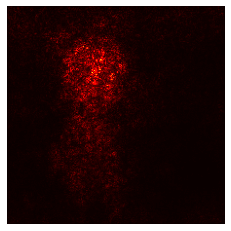

Mean ->  tensor(0.0173)
Max ->  tensor(0.6645)


In [6]:
#IMPORTS

import torch
import torchvision
import torchvision.transforms as T
import numpy as np
import matplotlib.pyplot as plt
from torchsummary import summary
from PIL import Image

#Using VGG-19 pretrained model for image classification

model = torchvision.models.vgg19(pretrained=True)
for param in model.parameters():
    param.requires_grad = False

# Opening the image
img = Image.open('/content/input.jpg')

# Preprocess the image
def preprocess(image, size=224):
    transform = T.Compose([
        T.Resize((size,size)),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        T.Lambda(lambda x: x[None]),
    ])
    return transform(image)

# preprocess the image
X = preprocess(img)

### YOUR CODE STARTS HERE ###
model.eval()
X.requires_grad_()
scores = model(X)
score_max_index = scores.argmax()
score_max = scores[0,score_max_index]
score_max.backward()
saliency, _ = torch.max(X.grad.data.abs(),dim=1)

plt.imshow(saliency[0],cmap=plt.cm.hot)
plt.axis('off')
plt.show()
print("Mean -> ",saliency[0].flatten().mean())

print("Max -> ",saliency[0].flatten().max())

### YOUR CODE ENDS HERE ###

### Question 2

Compute accumulated Attribution over all the input pixels of a given image towards a class (class id-243) output using Integrated Gradient(IG) Method. Assume baseline or reference image to be an image with all zero pixels. Also consider number of steps in IG approximation as 5 and all intermediate step images should follow linear path from baseline image to original image.

which of the following value is true for the estimation of accumulated attribution over all the input pixels across all the channels?

1.   0.9732
2.   0.6931
3.   0.8646
4.   0.5691



In [7]:
#IMPORTS
# https://github.com/utkuozbulak/pytorch-cnn-visualizations/blob/master/src/integrated_gradients.py


import torch
import torchvision
import torchvision.transforms as T
import numpy as np
import matplotlib.pyplot as plt
from torchsummary import summary
from PIL import Image

# Opening the image
img = Image.open('input.jpg') 

# Preprocess the image
def preprocess(image, size=224):
    transform = T.Compose([
        T.Resize((size,size)),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        T.Lambda(lambda x: x[None]),
    ])
    return transform(image)

# preprocess the image
X = preprocess(img)

# we need to find the gradient with respect to the input image, so we need to call requires_grad_ on it
X.requires_grad_()

class IG():
    """
        Compute attribution of classifier's output from each input pixels using 
        Integrated Gradient Methood 
    """
    def __init__(self, model):
        self.model = torchvision.models.vgg19(pretrained=True) 
        self.gradients = None
        # Put model in evaluation mode
        self.model.eval()
        # Hook the first layer to get the gradient
        self.hook_layers()

    def hook_layers(self):
        def hook_function(module, grad_in, grad_out):
            self.gradients = grad_in[0]

        # Register hook to the first layer
        first_layer = list(self.model.features._modules.items())[0][1]
        first_layer.register_backward_hook(hook_function)

    def create_images_on_linear_path(self, input_image, steps):
        ''' Create list of all intermediate step images on a linear path
            conneting baseline image to original input image
        '''
        ### YOUR CODE STARTS HERE
        step_list = np.arange(steps+1)/steps
        # Generate scaled xbar images
        xbar_list = [input_image*step for step in step_list]
        return xbar_list

        ### YOUR CODE ENDS HERE

    def compute_gradients(self, input_image, target_class):
        ''' Compute gradient of model's target class output w.r.t to all input pixels'''  

        ### YOUR CODE STARTS HERE
        model_output = self.model(input_image)
        # Zero grads
        self.model.zero_grad()
        # Target for backprop
        one_hot_output = torch.FloatTensor(1, model_output.size()[-1]).zero_()
        one_hot_output[0][target_class] = 1
        # Backward pass
        model_output.backward(gradient=one_hot_output)
        # Convert Pytorch variable to numpy array
        # [0] to get rid of the first channel (1,3,224,224)
        gradients_as_arr = self.gradients.data.numpy()[0]
        return gradients_as_arr
        ### YOUR CODE ENDS HERE

    def compute_integrated_gradients(self, input_image, target_class, steps):

        ''' Main computation of Integrated Gradient method'''
        # Generate xbar images
        x_list = self.create_images_on_linear_path(input_image, steps)
        # Initialize an iamge composed of zeros
        integrated_grads = np.zeros(input_image.size())
        for x_image in x_list:
            # Generate gradients from xbar images
            single_integrated_grad = self.compute_gradients(x_image, target_class)
            # Add rescaled grads from xbar images
            integrated_grads = integrated_grads + single_integrated_grad/steps
        # [0] to get rid of the first channel (1,3,224,224)
        return integrated_grads[0]

### YOUR CODE STARTS HERE
"""
Compute accumulated Attribution over all the input pixels of a given image towards a 
class (class id-243) output using Integrated Gradient(IG) Method. Assume baseline or 
reference image to be an image with all zero pixels. Also consider number of steps in 
IG approximation as 5 and all intermediate step images should follow linear path from 
baseline image to original image.

which of the following value is true for the estimation of accumulated attribution over 
all the input pixels across all the channels?

    0.9732
    0.6931
    0.8646
    0.5691

"""
# target_example = 0  # Snake
# (original_image, prep_img, target_class, file_name_to_export, pretrained_model) =\
#     get_example_params(target_example)
# Vanilla backprop
IG = IG(model)

# Generate gradients
integrated_grads = IG.compute_integrated_gradients(X, 243, 5)
print(integrated_grads.shape)

# Convert to grayscale
# grayscale_integrated_grads = convert_to_grayscale(integrated_grads)
# # Save grayscale gradients
# save_gradient_images(grayscale_integrated_grads, file_name_to_export + '_Integrated_G_gray')
print('Integrated gradients completed.')


### YOUR CODE ENDS HERE

(3, 224, 224)
Integrated gradients completed.


array([[ 6.28640022e-04,  4.71790179e-04, -7.19873693e-04, ...,
        -2.37141876e-04,  4.61009491e-04,  7.46059835e-04],
       [ 2.00946307e-03,  2.47148979e-03, -2.87200294e-03, ...,
         7.45005338e-04,  3.40490575e-03,  1.13380855e-03],
       [ 3.83952791e-03,  2.66269903e-03, -7.14470953e-03, ...,
         2.96603361e-03,  2.89257404e-03,  9.25557546e-04],
       ...,
       [-1.90397152e-04, -3.73419104e-03, -9.78820171e-04, ...,
        -7.51705671e-03, -1.64959332e-03, -4.94172244e-04],
       [ 3.91322210e-03,  5.65211645e-03,  4.92358443e-03, ...,
        -1.66636260e-03,  5.87963703e-04, -1.81716290e-03],
       [ 9.29549789e-04,  2.25439822e-03,  9.78397984e-05, ...,
        -2.18061500e-03, -2.83719713e-03, -4.07594775e-04]])

In [11]:
for j in range(integrated_grads.shape[1]):
  for k in range(integrated_grads.shape[2]):
    if integrated_grads[0][j][k] == integrated_grads[1][j][k] == integrated_grads[2][j][k]:
      print(integrated_grads[0][i][k])
      

## Question 3

For a given input image, Find out the channel index and the importance(weight) score of most important feauture map (out of all the feature maps of final convolution layer of a pretrained ResNet50 model) using Grad-CAM method for the class prediction corresponds to "highest logit score". Note that, Grad-CAM produce final heatmap using the weighted combination of the feature map activations, where weights corresponds to importance score.


1.   channel index - 708 ; importance score - 0.0046
2.   channel index - 569 ; importance score - 0.0039
3.   channel index - 1093 ; importance score - 0.0071
4.   channel index - 211 ; importance score - 0.0009


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.autograd import Function
from torchvision import models
# https://github.com/utkuozbulak/pytorch-cnn-visualizations/blob/master/src/gradcam.py

def process_image(img):
    means = [0.485, 0.456, 0.406]
    stds = [0.229, 0.224, 0.225]

    p_img = img.copy()[:, :, ::-1]
    for i in range(3):
        p_img[:, :, i] = p_img[:, :, i] - means[i]
        p_img[:, :, i] = p_img[:, :, i] / stds[i]
    p_img = np.ascontiguousarray(np.transpose(p_img, (2, 0, 1)))
    p_img = torch.from_numpy(p_img)
    p_img.unsqueeze_(0)
    input = p_img.requires_grad_(True)
    return input

class Feat_Extractor():
    """ register gradients get activations from targetted intermediate layers """
    def __init__(self, model, target_layers):
        self.model = model
        self.target_layers = target_layers
        self.gradients = []

    def save_gradient(self, grad):
        self.gradients.append(grad)

    def __call__(self, x):
        outputs = []
        self.gradients = []
        for name, module in self.model._modules.items():
            x = module(x)
            if name in self.target_layers:
                x.register_hook(self.save_gradient)
                outputs += [x]
        return outputs, x


class Netout():
    """ Get network output through forward pass and get intermediate layer representation
    and gradient computation for targeted intermediate layer  """

    def __init__(self, net, feat_module, target_layers):
        self.model = net
        self.feature_module = feat_module
        self.feature_extractor = Feat_Extractor(self.feature_module, target_layers)

    def get_gradients(self):
        return self.feature_extractor.gradients

    def __call__(self, x):
        target_activations = []
        for name, module in self.model._modules.items():
            if module == self.feature_module:
                target_activations, x = self.feature_extractor(x)

            elif "avgpool" in name.lower():
                x = module(x)
                x = x.view(x.size(0),-1)
    
            else:
                x = module(x)
        
        return target_activations, x


#visualize heatmap on input image
def visualize(img, mask):
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    img = np.uint8(255 * cam)
    plt.imshow(img)


class GradientCam:
    def __init__(self, model, feature_module, target_layer_, cuda):
        self.model = model
        self.feature_module = feature_module
        self.model.eval()
        self.cuda = cuda
        if self.cuda:
            self.model = model.cuda()

        self.extractor = Netout(self.model, self.feature_module, target_layer_)

    def forward(self, input):
        return self.model(input)

    def __call__(self, input, index=None):
        
        ''' This function should Return weights corresponding to each feature map of last convolution layer.
        Note that, linear combination of such weights with last conv layer feature map finally 
        produce the explanation map'''

        ### YOUR CODE STARTS HERE
        conv_output, model_output = self.extractor.forward_pass(input_image)
        
        ### YOUR CODE ENDS HERE


if __name__ == '__main__':
    
    image = cv2.imread('/content/input.jpg', 1)
    image = np.float32(cv2.resize(image, (224, 224))) / 255
    input = process_image(image)

    net = models.resnet50(pretrained=True)
    grad_cam = GradientCam(model=net, feature_module=net.layer4, \
                       target_layer_=["2"], cuda=False)
    

    target_index = None

    ### call to grad_cam method should return the importance vector corresponds to
    ### each feature map of last convolution layer of pretrained Resnet50

    weights, class_activation_map = grad_cam(input, target_index)

    print ("Most important feature map index: ", np.argmax(weights))
    print ("Its corresponding importance is: ", np.max(weights))

    visualize(image, class_activation_map)